In [4]:
import pandas as pd
import numpy as np 
import os

In [23]:
import matplotlib.pyplot as plt

In [2]:
import xgboost

In [3]:
import mlflow

In [5]:
os.listdir('data')

['Lyrics-Genre-Test-GroundTruth.csv', 'Lyrics-Genre-Train.csv']

In [8]:
TRAIN_PATH = 'data/Lyrics-Genre-Train.csv'
TEST_PATH = 'data/Lyrics-Genre-Test-GroundTruth.csv'

In [9]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

In [26]:
X_train, Y_train = train_data['Lyrics'], train_data['Genre']

X_test, Y_test = test_data['Lyrics'], test_data['Genre']

#### EDA

In [11]:
train_data.shape

(18513, 6)

In [13]:
train_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260


In [12]:
test_data.shape

(7935, 6)

In [14]:
test_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797


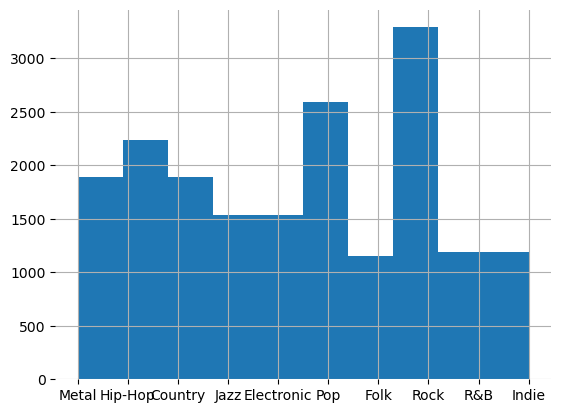

In [25]:
train_data['Genre'].hist(grid = .25)
plt.box(False)


In [18]:
train_data.groupby('Genre')['Lyrics']

#### Modeling